In [48]:
# LINEAR REGRESSION 

# 2 main ways 
    # statsmodel 
        # exactly like (R) e.g. with formula notaion
    # scikit learn 
        # for ML style = don't do feature selection manually 
        # automated all the feature selection = just select cost function
        # you want to minimise (e.g. stepwise/reach/lasso)

In [49]:
# Load libraries 
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as sm
import statsmodels.api as sma
from statsmodels.tools.eval_measures import mse
from statsmodels.tools.tools import add_constant

from sklearn import linear_model,cross_validation, feature_selection,preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import KFold

In [50]:
# LINEAR REGRESSION WITH SCIKIT-LEARN
# For this example I explicitly chose a dataset with poor correlation to demonstrate how to spot a linear regression that does not work well


# STEP 1: LOAD DATA (AND DESCRIBE)

data = pd.read_csv('soccer_fantasy.csv')
pd.set_option('precision',3)
data.describe()
# describe is str()

,m_dash,weight,shots_on_target_rate,penalty_rate,avg_fantasy_points
count,54.000,54.000,54.000,54.000,54.000
mean,6.587,209.907,0.449,0.742,11.791
std,0.459,30.265,0.057,0.100,5.899
min,5.700,105.000,0.291,0.244,2.800
25%,6.225,185.000,0.415,0.713,8.150
50%,6.650,212.500,0.444,0.754,10.750
75%,6.900,235.000,0.483,0.795,13.600
max,7.600,263.000,0.599,0.900,27.400


In [51]:
# STEP 2: CORRELATION OF VARIABLES (INTERPRET)
# It is important to start by taking time to examine and interpret correlation between each variable  

data.corr()

,m_dash,weight,shots_on_target_rate,penalty_rate,avg_fantasy_points
\tm_dash,1.000,0.834,0.496,-0.259,-0.069
weight,0.834,1.000,0.516,-0.290,-0.010
shots_on_target_rate,0.496,0.516,1.000,-0.019,0.339
penalty_rate,-0.259,-0.290,-0.019,1.000,0.245
avg_fantasy_points,-0.069,-0.010,0.339,0.245,1.000


C:\Users\samue\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  after removing the cwd from sys.path.


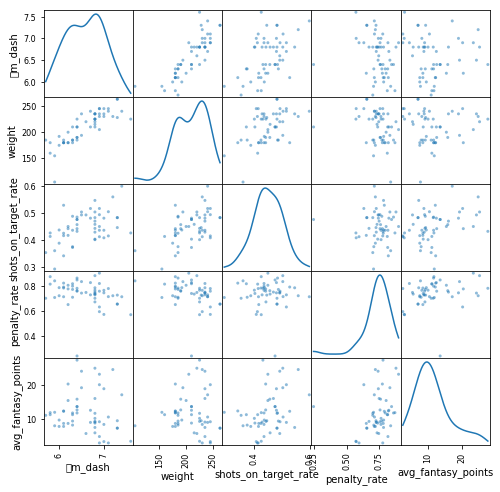

In [52]:
# Correlation plots are a very useful way of seeing the correlation between all variables (as well as their distribution)

from pandas.tools.plotting import scatter_matrix
scatter_matrix(data,figsize=(8, 8), diagonal='kde');

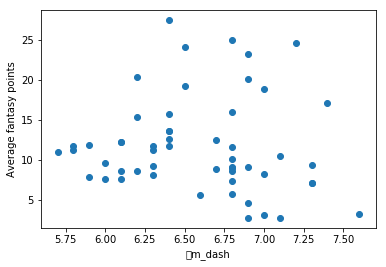

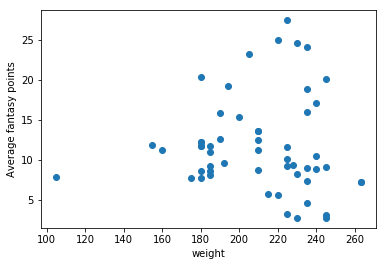

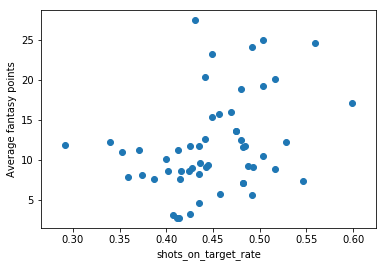

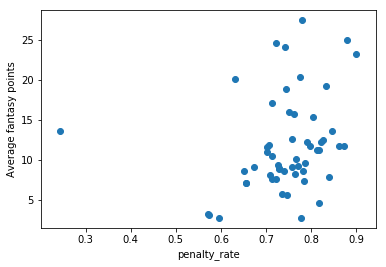

In [53]:
# STEP 3: PLOT 2 WAY AND 3 WAY SCATTER PLOTS BETWEEN VAIRABLES TO EXPLORE INTERESTING RELATIONSHIPS FURTHER

# For this example I am using 'Fantasy points' as the dependent variable (y)
# It is useful at an early stage to compare all variables agains this dependent variable to explore relationships 
data_x = data.columns[:-1]

for i in data_x:
    fig, ax = plt.subplots(1, 1)  
    ax.scatter(data[i], data.avg_fantasy_points)
    ax.set_xlabel(i)
    ax.set_ylabel('Average fantasy points')
    plt.show()

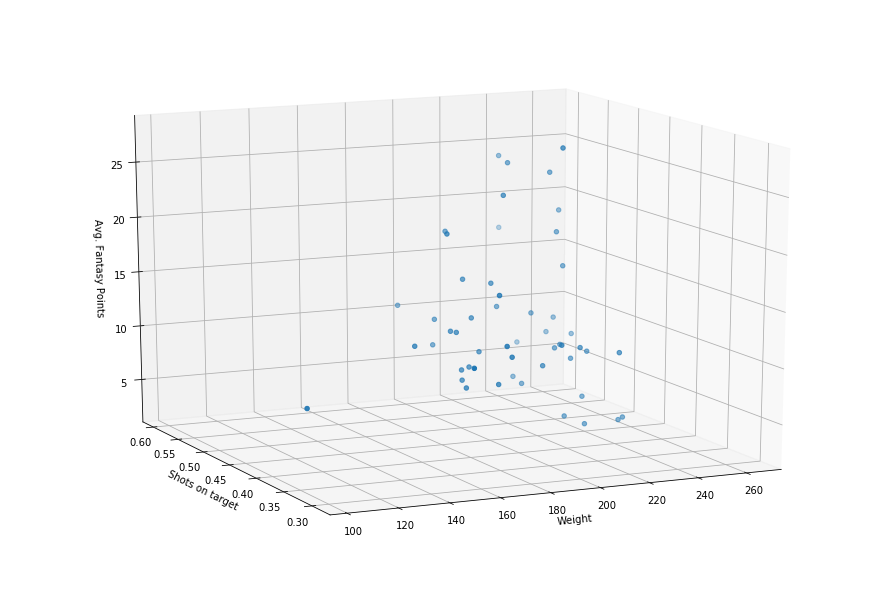

In [54]:
# 3d plots
# it may also be useful to explore 3 way correlations (though these can often be difficult to see visually)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = Axes3D(fig, azim=-115, elev=15)
ax.scatter(data['weight'], data['shots_on_target_rate'], 
           data['avg_fantasy_points'])
ax.set_xlabel('Weight')
ax.set_ylabel('Shots on target')
ax.set_zlabel('Avg. Fantasy Points')
plt.show()

In [55]:
## STEP 4: CREATE TRAIN/TEST/VALIDATION SPLITS 
# always a good idea to save a copy of the data before hand 
X =  data.copy() 

# SciKit comes with functions to automate cross validation
train,test = cross_validation.train_test_split(X,train_size=0.80)

X =  train.values.copy() 
X_t = test.values.copy()

x_train= X[:, :-1]
y_train= X[:, -1]

x_test=X_t[:, :-1]
y_test= X_t[:, -1]

In [56]:
# STEP 5: BUILD MODEL AND FIT IT TO TEST SET 

# USING SCIKIT LEARN 
# train / test are the other way around - careful
# zip = combines datacolumsn with the coefficient 
# ZIP DOESNT WORK IN PYTHON 3.X 
# zip gives line by line
# list keeps taking the lines of the zip until you have all of them 


# Create linear regression object
lm = linear_model.LinearRegression(fit_intercept=True)

# Train the model using the training sets
lm.fit(x_train, y_train)

print ("Intercept is " + str(lm.intercept_) + '\n')

pd.DataFrame(list(zip(data.columns,lm.coef_)), columns = ['features', 'Coeffs'])

Intercept is 16.2275765866



,features,Coeffs
0,\tm_dash,-6.535
1,weight,0.040
2,shots_on_target_rate,55.949
3,penalty_rate,7.112


In [57]:
# STEP 6: CHECK ERROR SCORES

#Score gives you R squared ocefficied 
lm.score(x_train,y_train)

# CROSS VALIDATION 

# Compute RMSE on training data
p = lm.predict(x_train)
# Now we can constuct a vector of errors
err = abs(p-y_train)

# Dot product of error vector with itself gives us the sum of squared errors
total_error = np.dot(err,err)
# Compute RMSE
rmse_train = np.sqrt(total_error/len(p))
rmse_train

5.1661376149708031

In [58]:
# STEP 7: K-FOLD 10-FOLD CROSS VALIDATION 

# If we want to test further we can compute RMSE using 10-fold x-validation
X =  data.copy()
x = X.iloc[:, :-1].values
y = X.iloc[:, -1].values

kf = KFold(len(x), n_folds=10)
xval_err = 0
for train,test in kf:
    lm.fit(x[train],y[train])
    p = lm.predict(x[test])
    e = p-y[test]
    xval_err += np.dot(e,e)
    
rmse_10cv = np.sqrt(xval_err/len(x))

print('RMSE on training: ',rmse_train)
print('RMSE on 10-fold CV: ',rmse_10cv)

RMSE on training:  5.16613761497
RMSE on 10-fold CV:  5.81976929412


In [59]:
# Repeated cross validation  
#By default you get three runs
cross_validation.cross_val_score(lm, x_train, y_train,cv=5, scoring='r2')
# the model is clearly poor 

array([-0.52049316, -0.13093713,  0.09692092,  0.50904153, -0.32914741])

In [60]:
# Predict specific points using SKlearn (each number is a value of the variables - output is the dependant variable)
lm.predict([[6.8,225,0.6,0.7]])

array([ 17.84301869])

In [61]:
# Calculate R^2 score SKlearn

lm.score(x_train,y_train)
# terrible, would be more like 0.8 if good 

0.25649776315244588

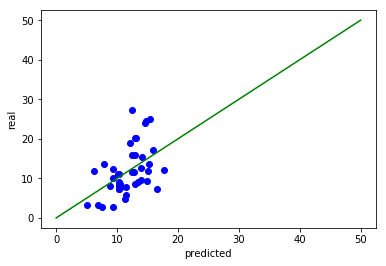

In [62]:
# plot actual vs predicted SKlearn

p = lm.predict(x_train)
plt.plot(p, y_train,'bo')
plt.plot([0,50],[0,50], 'g-')
plt.xlabel('predicted')
plt.ylabel('real')
plt.show()

# La# again would be way tighter if model was good 

In [70]:
## ALGORITHMIC FEATURE SELECTION (LASSO/Ridge METHODS)
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet


#LASSO
#Lasso  Fit a Lasso regression with alpha value of 0.4
lasso = linear_model.Lasso(fit_intercept=True, alpha=0.4)
lasso.fit(x_train,y_train)
lasso.coef_

# RIDGE
# Create linear regression object with a ridge coefficient 0.5
ridge = linear_model.Ridge(fit_intercept=True, alpha=0.5)

# Train the model using the training set
ridge.fit(x_train,y_train)

# ALPHA = How much you want to shrink the model
# If it is zero then traditional linear regression
# infiite will give you no variables
# ridge regression is just for looping alpha and testing RMSE


Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [71]:
# Compute RMSE on training data
p = ridge.predict(x)
err = p-y
total_error = np.dot(err,err)
rmse_train = np.sqrt(total_error/len(p))

# Compute RMSE using 10-fold x-validation
kf = KFold(len(x), n_folds=10)
xval_err = 0
for train,test in kf:
    ridge.fit(x[train],y[train])
    p = ridge.predict(x[test])
    e = p-y[test]
    xval_err += np.dot(e,e)
rmse_10cv = np.sqrt(xval_err/len(x))

print('RMSE on training:',rmse_train)
print('RMSE on 10-fold CV: ',rmse_10cv)

RMSE on training: 5.5526841885
RMSE on 10-fold CV:  5.83343772613


In [72]:
print('Ridge Regression')
print('alpha\t RMSE_train\t RMSE_10cv\t TOT_COEFF\n')
alpha = np.linspace(.01,20,50)
t_rmse = np.array([])
cv_rmse = np.array([])

for a in alpha:
    ridge = linear_model.Ridge(fit_intercept=True, alpha=a)
    
    # computing the RMSE on full data
    ridge.fit(x,y)
    p = ridge.predict(x)
    err = p-y
    total_error = np.dot(err,err)
    rmse_train = np.sqrt(total_error/len(p))

    # computing RMSE using 10-fold cross validation
    kf = KFold(len(x), n_folds=10)
    xval_err = 0
    for train, test in kf:
        ridge.fit(x[train], y[train])
        p = ridge.predict(x[test])
        err = p - y[test]
        xval_err += np.dot(err,err)
    rmse_10cv = np.sqrt(xval_err/len(x))
    tot = np.sum(ridge.coef_)
    
    t_rmse = np.append(t_rmse, [rmse_train])
    cv_rmse = np.append(cv_rmse, [rmse_10cv])
    print('{:.3f}\t {:.4f}\t\t {:.4f}\t\t {:.4f}\t'.format(a,rmse_train,rmse_10cv,tot))
    
    
    
    # SMALLER COEFFICENTS ARE BETTER AS THERE IS NOT SUCH LARGE SWINGS 

Ridge Regression
alpha	 RMSE_train	 RMSE_10cv	 TOT_COEFF

0.010	 5.1571		 5.8033		 50.9782	
0.418	 5.4736		 5.8217		 15.0341	
0.826	 5.5822		 5.8688		 8.7781	
1.234	 5.6377		 5.8964		 6.0415	
1.642	 5.6721		 5.9139		 4.5180	
2.050	 5.6959		 5.9260		 3.5578	
2.458	 5.7134		 5.9348		 2.9037	
2.866	 5.7268		 5.9414		 2.4333	
3.274	 5.7376		 5.9467		 2.0810	
3.682	 5.7464		 5.9509		 1.8089	
4.090	 5.7538		 5.9544		 1.5933	
4.498	 5.7601		 5.9573		 1.4190	
4.906	 5.7655		 5.9598		 1.2756	
5.313	 5.7702		 5.9619		 1.1559	
5.721	 5.7744		 5.9638		 1.0548	
6.129	 5.7780		 5.9654		 0.9683	
6.537	 5.7814		 5.9669		 0.8937	
6.945	 5.7843		 5.9682		 0.8288	
7.353	 5.7870		 5.9694		 0.7718	
7.761	 5.7895		 5.9705		 0.7216	
8.169	 5.7917		 5.9714		 0.6769	
8.577	 5.7938		 5.9723		 0.6370	
8.985	 5.7957		 5.9731		 0.6011	
9.393	 5.7975		 5.9739		 0.5688	
9.801	 5.7991		 5.9745		 0.5395	
10.209	 5.8006		 5.9752		 0.5128	
10.617	 5.8020		 5.9758		 0.4884	
11.025	 5.8033		 5.9763		 0.4661	
11.433	 5.804

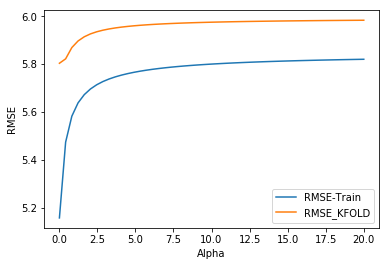

In [73]:
#Better with a graph...
plt.plot(alpha, t_rmse, label='RMSE-Train')
plt.plot(alpha, cv_rmse, label='RMSE_KFOLD')

plt.legend( ('RMSE-Train', 'RMSE_KFOLD') )
plt.ylabel('RMSE')
plt.xlabel('Alpha')
plt.show()


In [75]:
## CHOOSING BETWEEN DIFFERENT ALGORTHM SELECTION
# lasso ridge elastic-net comparing 

a = 0.3
for name,met in [
        ('linear regression', linear_model.LinearRegression()),
        ('lasso', linear_model.Lasso(fit_intercept=True, alpha=a)),
        ('ridge', linear_model.Ridge(fit_intercept=True, alpha=a)),
        ('elastic-net', linear_model.ElasticNet(fit_intercept=True, alpha=a))
        ]:
    met.fit(x,y)
    p = met.predict(x)
    e = p-y
    total_error = np.dot(e,e)
    rmse_train = np.sqrt(total_error/len(p))

    kf = KFold(len(x), n_folds=10)
    err = 0
    for train,test in kf:
        met.fit(x[train],y[train])
        p = met.predict(x[test])
        e = p-y[test]
        err += np.dot(e,e)

    rmse_10cv = np.sqrt(err/len(x))
    print('Method: %s' %name)
    print('RMSE on full data: %.4f' %rmse_train)
    print('RMSE on 10-fold CV: %.4f' %rmse_10cv)
    print("\n")

Method: linear regression
RMSE on full data: 5.1542
RMSE on 10-fold CV: 5.8198


Method: lasso
RMSE on full data: 5.8441
RMSE on 10-fold CV: 5.9891


Method: ridge
RMSE on full data: 5.4179
RMSE on 10-fold CV: 5.8028


Method: elastic-net
RMSE on full data: 5.8424
RMSE on 10-fold CV: 6.0028




In [76]:
## COST FUNCTIONS  = optimising information criteria AIC BIC feature selection

#SciKit doesn´t provide a summary function so we need to code our own

def sum_model(coefs, names = None, sort = False):
    if names is None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = list(zip(coefs, names))
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return " + ".join("%s * %s" % (round(coef, 3), name)
                                   for coef, name in lst)
    print("Linear model:", pretty_print_linear(lr.coef_))
    
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(x_train)
Y = y_train
names = data.columns[:-1].values
  
lasso = Lasso(alpha=.25)
lasso.fit(X, Y)
  
print ("Lasso model: ", sum_model(lasso.coef_, names, 
                                            sort = True))

Lasso model:  2.966 * shots_on_target_rate + -1.636 * 	m_dash + 0.548 * penalty_rate + 0.0 * weight


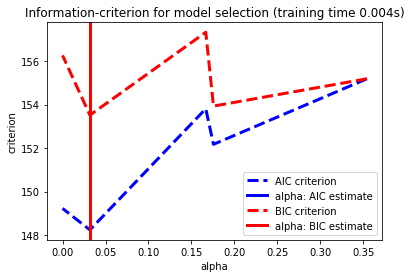

array([-157.86103231,    0.        ,  151.3563623 ,   26.58838384])

In [77]:
#picking the right alpha 

import time


from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC

X = x_train
y = y_train



# normalize data as done by Lars to allow for comparison
X /= np.sqrt(np.sum(X ** 2, axis=0))

model_bic = LassoLarsIC(criterion='bic')
t1 = time.time()
model_bic.fit(X, y)
t_bic = time.time() - t1
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X, y)
alpha_aic_ = model_aic.alpha_


def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
    plt.plot(alphas_, criterion_, '--', color=color,
             linewidth=3, label='%s criterion' % name)
    plt.axvline(alpha_, color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel('alpha')
    plt.ylabel('criterion')

plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
plt.title('Information-criterion for model selection (training time %.3fs)'
          % t_bic)
plt.show()

## BOTH HAVE THE SAME ALPHA POINT 
# LASSOLARSIC fits itself <- you only need to provide cost function you want 

model_aic.coef_

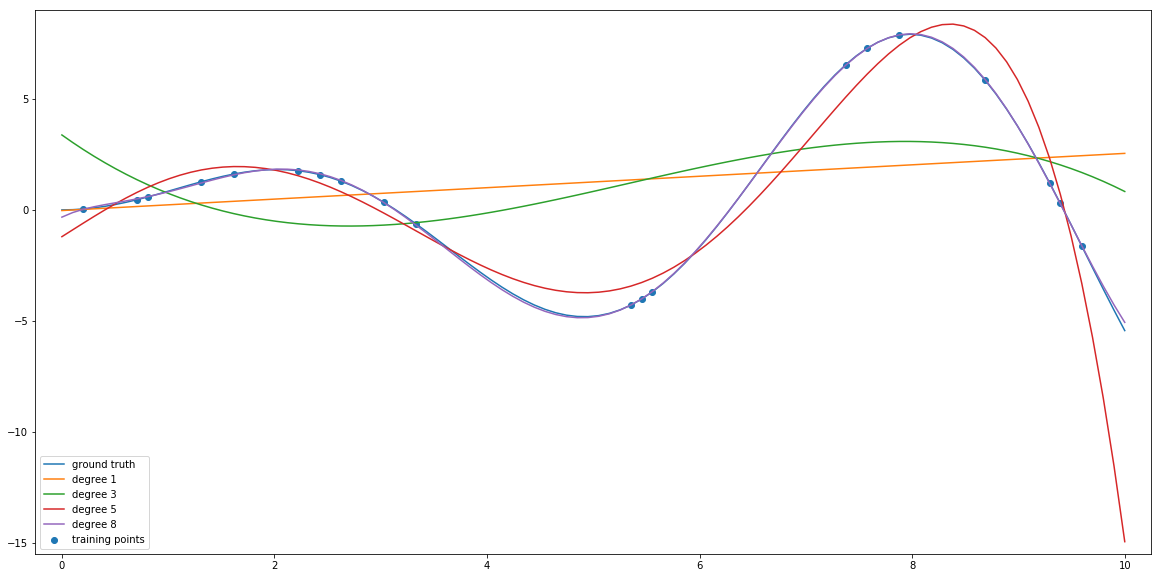

In [78]:
# ### Example of Polynomial Regression

## polynomial regression

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
 
# function to approximate by polynomial interpolation
def f(x): return x * np.sin(x)
 
# generate points used to plot
x_plot = np.linspace(0, 10, 100)
 
# generate points and keep a subset of them
x = np.linspace(0, 10, 100)
rng = np.random.RandomState(0)
rng.shuffle(x)
x = np.sort(x[:20])
y = f(x)
 
# create matrix versions of these arrays
X = x[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]
 
plt.figure(figsize=(20,10))
plt.plot(x_plot, f(x_plot), label="ground truth")
plt.scatter(x, y, label="training points")
 
for degree in [1, 3, 5, 8]:
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X, y)
    y_plot = model.predict(X_plot)
    plt.plot(x_plot, y_plot, label="degree %d" % degree)
 
plt.xlim([-0.25,10.25])
plt.ylim([-15.5,9])
plt.legend(loc='lower left')
 
plt.show()


In [79]:
# You should also make sure to test the assumptions and statistical tests (see statsmodel repository: https://github.com/samueldtking/Linear_regression)